In [1]:
# Deep Learning Libraries

from functools import partial

import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ttest_rel, mannwhitneyu

# General Libraries
from scipy.io import loadmat, savemat
from scipy.fft import fft, fftfreq, ifft
import h5py
import os

# Import Explainability Results

In [4]:
# LOAD FILENAMES OF EXPLAINABILITY RESULTS FROM DIRECTORY

load_dir = '/data/users2/cellis42/Spectral_Explainability/DataAugmentation/EMBC2024/Importance/'
file_paths = np.sort(os.listdir(load_dir))
for file_path in file_paths:
    print(file_path)

Model_m1_v1_importance_ISBI.mat
Model_m1_v2_importance_ISBI.mat
Model_m1_v3_importance_ISBI.mat
Model_m2_importance_ISBI.mat
Model_m2_v2_importance_ISBI.mat
Model_m3_importance_ISBI.mat
Model_m4_importance_ISBI.mat
Model_m4_v2_importance_ISBI.mat
Model_m5_importance_ISBI.mat
Model_m5_v2_importance_ISBI.mat
Model_m6_importance_ISBI.mat
Model_m6_v2_importance_ISBI.mat
Model_m7_importance_ISBI.mat
Model_m7_v2_importance_ISBI.mat


In [5]:
# LOAD EXPLAINABILITY RESULTS FROM FILES

spectral_importance_vals = []; spatial_importance_vals = [];
for file_path in file_paths:
    spectral_importance_vals.append(loadmat(os.path.join(load_dir,file_path),appendmat=True)['spectral_importance'])
    spatial_importance_vals.append(loadmat(os.path.join(load_dir,file_path),appendmat=True)['spatial_importance'])

    
spectral_importance_vals = np.array(spectral_importance_vals)
spatial_importance_vals = np.squeeze(np.array(spatial_importance_vals))

In [6]:
# STORE NAMES OF FREQUENCY BANDS AND CHANNELS IN SEPARATE ARRAYS

freq_bands = [r'$\mathbf{\delta}$',r'$\mathbf{\theta}$',r'$\mathbf{\alpha}$',r'$\mathbf{\beta}$',r'$\mathbf{\gamma}_1$',r'$\mathbf{\gamma}_2$',r'$\mathbf{\gamma}_3$']
channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

# Plot Spectral Explainability Results

In [7]:
# STORE MODEL NAMES
index = ['M1.1','M1.2','M1.3','M2.1','M2.2','M3.1','M4.1','M4.2','M5.1','M5.2','M6.1','M6.2','M7.1','M7.2']

In [8]:
# MAKE ARRAY INDICATING WHICH AUGMENTATION APPROACH EACH MODEL CORRESPONDS TO
index2 = [0, 0, 0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 6, 6]

In [9]:
# DEFINE FUNCTION FOR CREATING BOXPLOT INDICES

def get_idx(n_features,n_groups_total,n_groups):
    # n_features - number of features to include in feature group
    # n_groups_total - number of feature groups in boxplot (i.e., number of models to include in plot)
    # n_groups = n_groups
    
    idx = np.arange(n_features)+ (n_features * (n_groups_total-n_groups)+ (n_groups_total-n_groups))
    
    if n_groups > 1:
        idx = np.hstack((idx,get_idx(n_features,n_groups_total,n_groups-1)))
    
    return idx

In [10]:
# DEFINE FUNCTION FOR CREATING BOXPLOT TICK LABELS
def get_labels(freq_bands,n_groups):
    # freq_bands - array of frequency band names for use in tick labels
    # n_groups - number of feature groups in boxplot (i.e., number of models to include in plot)
    
    freq_bands2 = freq_bands
    
    if n_groups > 1:
        freq_bands2 = np.hstack((freq_bands2, get_labels(freq_bands,n_groups-1)))
    
    return(freq_bands2)

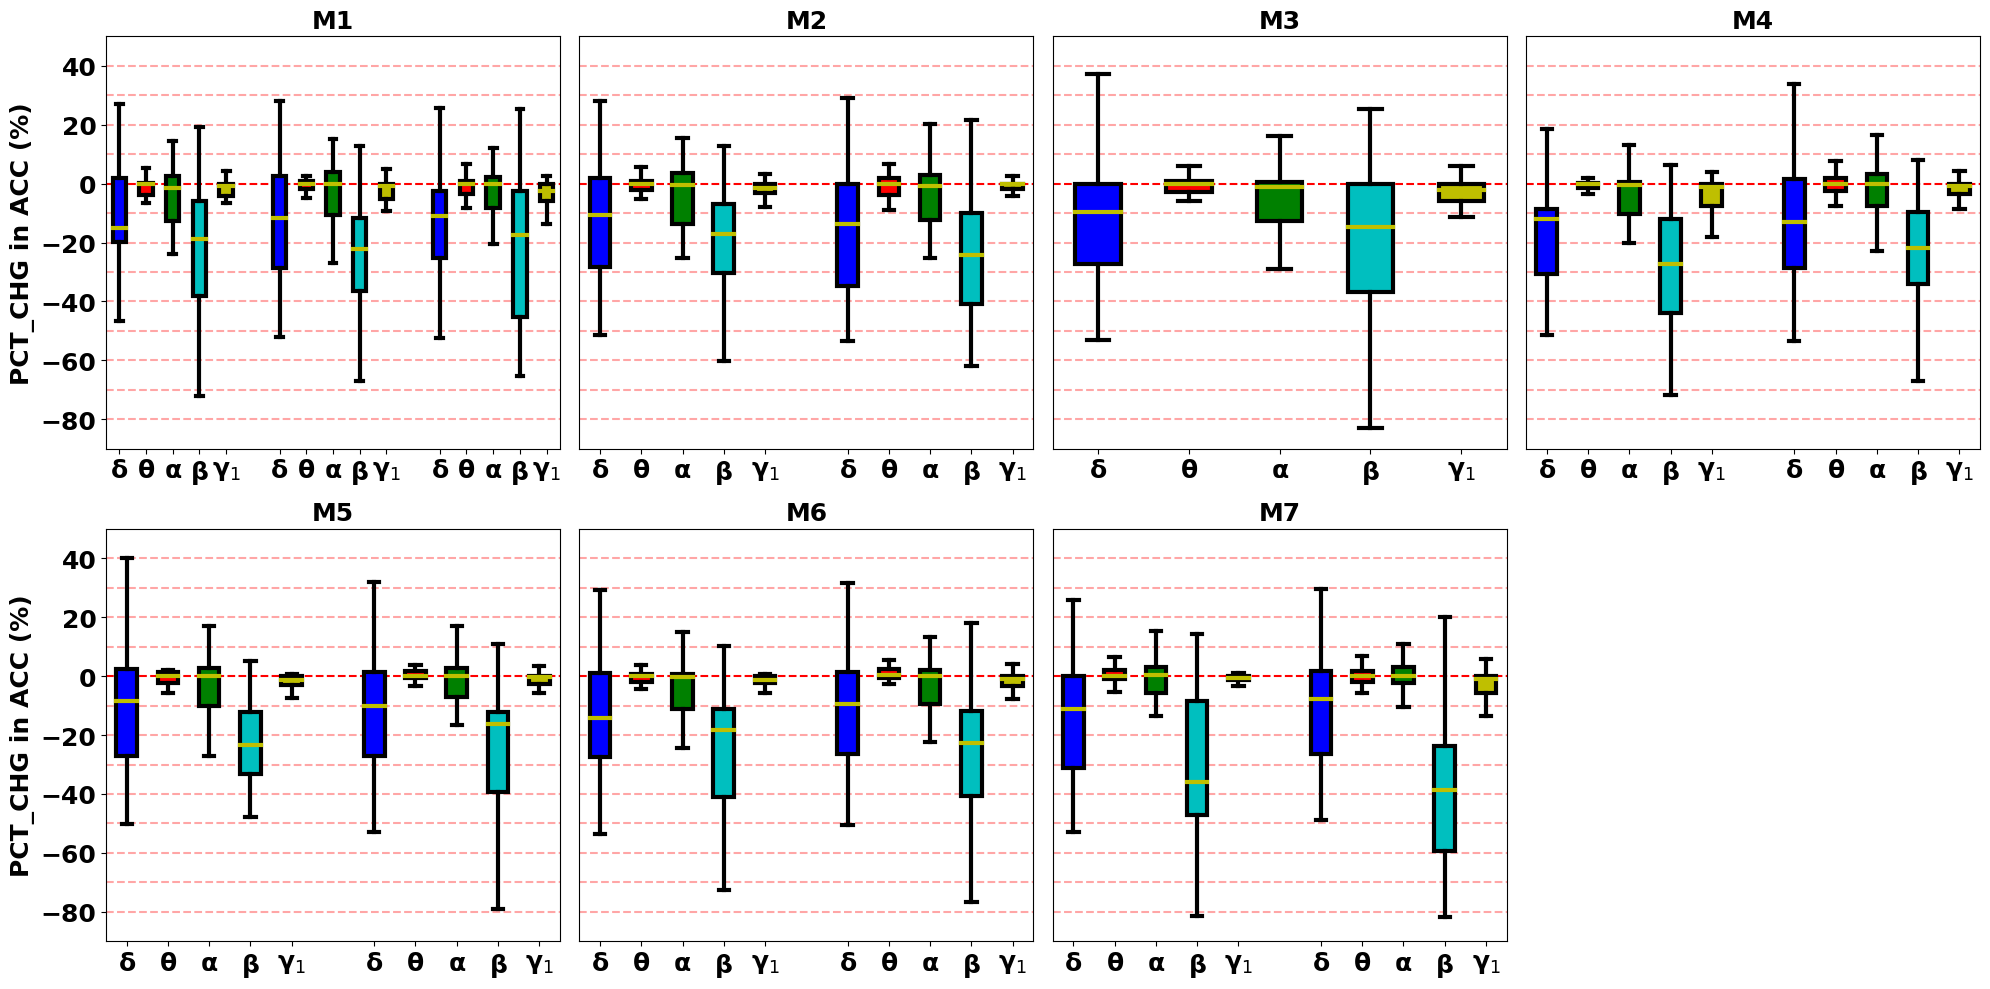

In [17]:
# PLOT SPECTRAL EXPLAINABILITY RESULTS

# Remove Last Two Gamma Band Values
spectral_importance_vals = spectral_importance_vals[:,:,:5]
freq_bands = freq_bands[:5]

# Titles for Each Subplot
titles = ['M1','M2','M3','M4','M5','M6','M7']

# Make Figure
plt.figure(figsize=(20,10))
for i in np.arange(np.max(index2)+1):
    plt.subplot(2,int(np.ceil((np.max(index2)+1)/2)),i+1)
    
    # Get X Indices
    model_idx = i*np.ones_like(index2)== index2
    n_models = np.sum(model_idx)
    n_freq_bands = np.shape(spectral_importance_vals)[2]
    x_idx = get_idx(n_freq_bands,n_models,n_models)
    
    # Get X-Tick Labels
    freq_bands2 = get_labels(freq_bands,n_models)
    
    # Plot Horizontal Lines
    for hline in range(-8,5):
        if hline != 0:
            plt.hlines([10*hline],-0.5,np.max(x_idx)+0.5,'r','--',alpha=0.35)
        else:
            plt.hlines([10*hline],-0.5,np.max(x_idx)+0.5,'r','--',alpha=1)
    
    # Rearrange Data
    spec_imp = []
    for m in range(n_models):
        spec_imp.extend(spectral_importance_vals[model_idx,:,:][m,:,:].T)
        
    bplot = plt.boxplot(spec_imp,positions=x_idx,patch_artist=True,showfliers=False)
    
    plt.xticks(x_idx,freq_bands2,fontsize=18)
    plt.yticks(weight='bold',fontsize=18)
    plt.title(titles[i],weight='bold',fontsize=18)
    plt.ylim([-90,50])
    
    if i == 0 or i == 4:
        plt.ylabel('PCT_CHG in ACC (%)',weight='bold',fontsize=18)
    else:
        plt.yticks([])
        
    # Set Whisker Color
    for whisker in bplot['whiskers']:
        whisker.set(color='k',linewidth=3)
    
    # Set Caps Color
    for cap in bplot['caps']:
        cap.set(color='k',linewidth=3)
    
    # Set Box Outline Color
    for box in bplot['boxes']:
        box.set(color='k',linewidth=3)
        
    # Set Median Color
    for med in bplot['medians']:
        med.set(color='y',linewidth=3)
    
    # Set Face color
    for count_outer in range(0,n_models):
        colors = ['b','r','g','c','y','w','tab:pink']
        for count in range(n_freq_bands):
            patch = bplot['boxes'][count + (count_outer*n_freq_bands)]
            color = colors[count]
            patch.set_facecolor(color)
plt.tight_layout()

    
plt.savefig('/home/users/cellis42/Spectral_Explainability/DataAugmentation/EMBC2024/Spectral_Importance.png')

# Plot Spatial Explainability Results

In [18]:
# GET RANKS FOR EACH FEATURE BASED ON ARGSORT OUTPUT
def get_ranks(arg_sort_output):
    
    ranks = np.zeros_like(arg_sort_output)
    
    count = 0
    for i in list(arg_sort_output):
        
        ranks[i] += count
        
        count += 1
    
    return ranks

In [19]:
# GET FEATURE RANKS


# Get Mean Absolute Importance for Each Feature
mean_abs_importance = np.mean(np.abs(spatial_importance_vals),axis=1) # get mean absolute importance across folds

# Get Ranks for Each Model
ranks = []
for i in range(np.shape(spatial_importance_vals)[0]):
    ranks.append(get_ranks(np.argsort(-1*mean_abs_importance[i,:])))

# Find Number of Models for which Channel is in Top 10
n_times_in_top10 = np.sum(ranks<10*np.ones_like(ranks),axis=0)+1 # add one in case one channel is never in top ten

# Rank Channels Based on Frequency of Appearance in Top 10
rank_in_top10 = get_ranks(np.argsort(-1*n_times_in_top10)) # get rank based on how often channel is in top 10

# Index of 10 Channels that Appear in Top 10 Most Frequently
include_in_top10 = rank_in_top10 < 10

In [20]:
# File Path to Electrode Diagram
image_path = '/home/users/cellis42/Spectral_Explainability/DataAugmentation/EMBC2024/10_20_system.jpg'

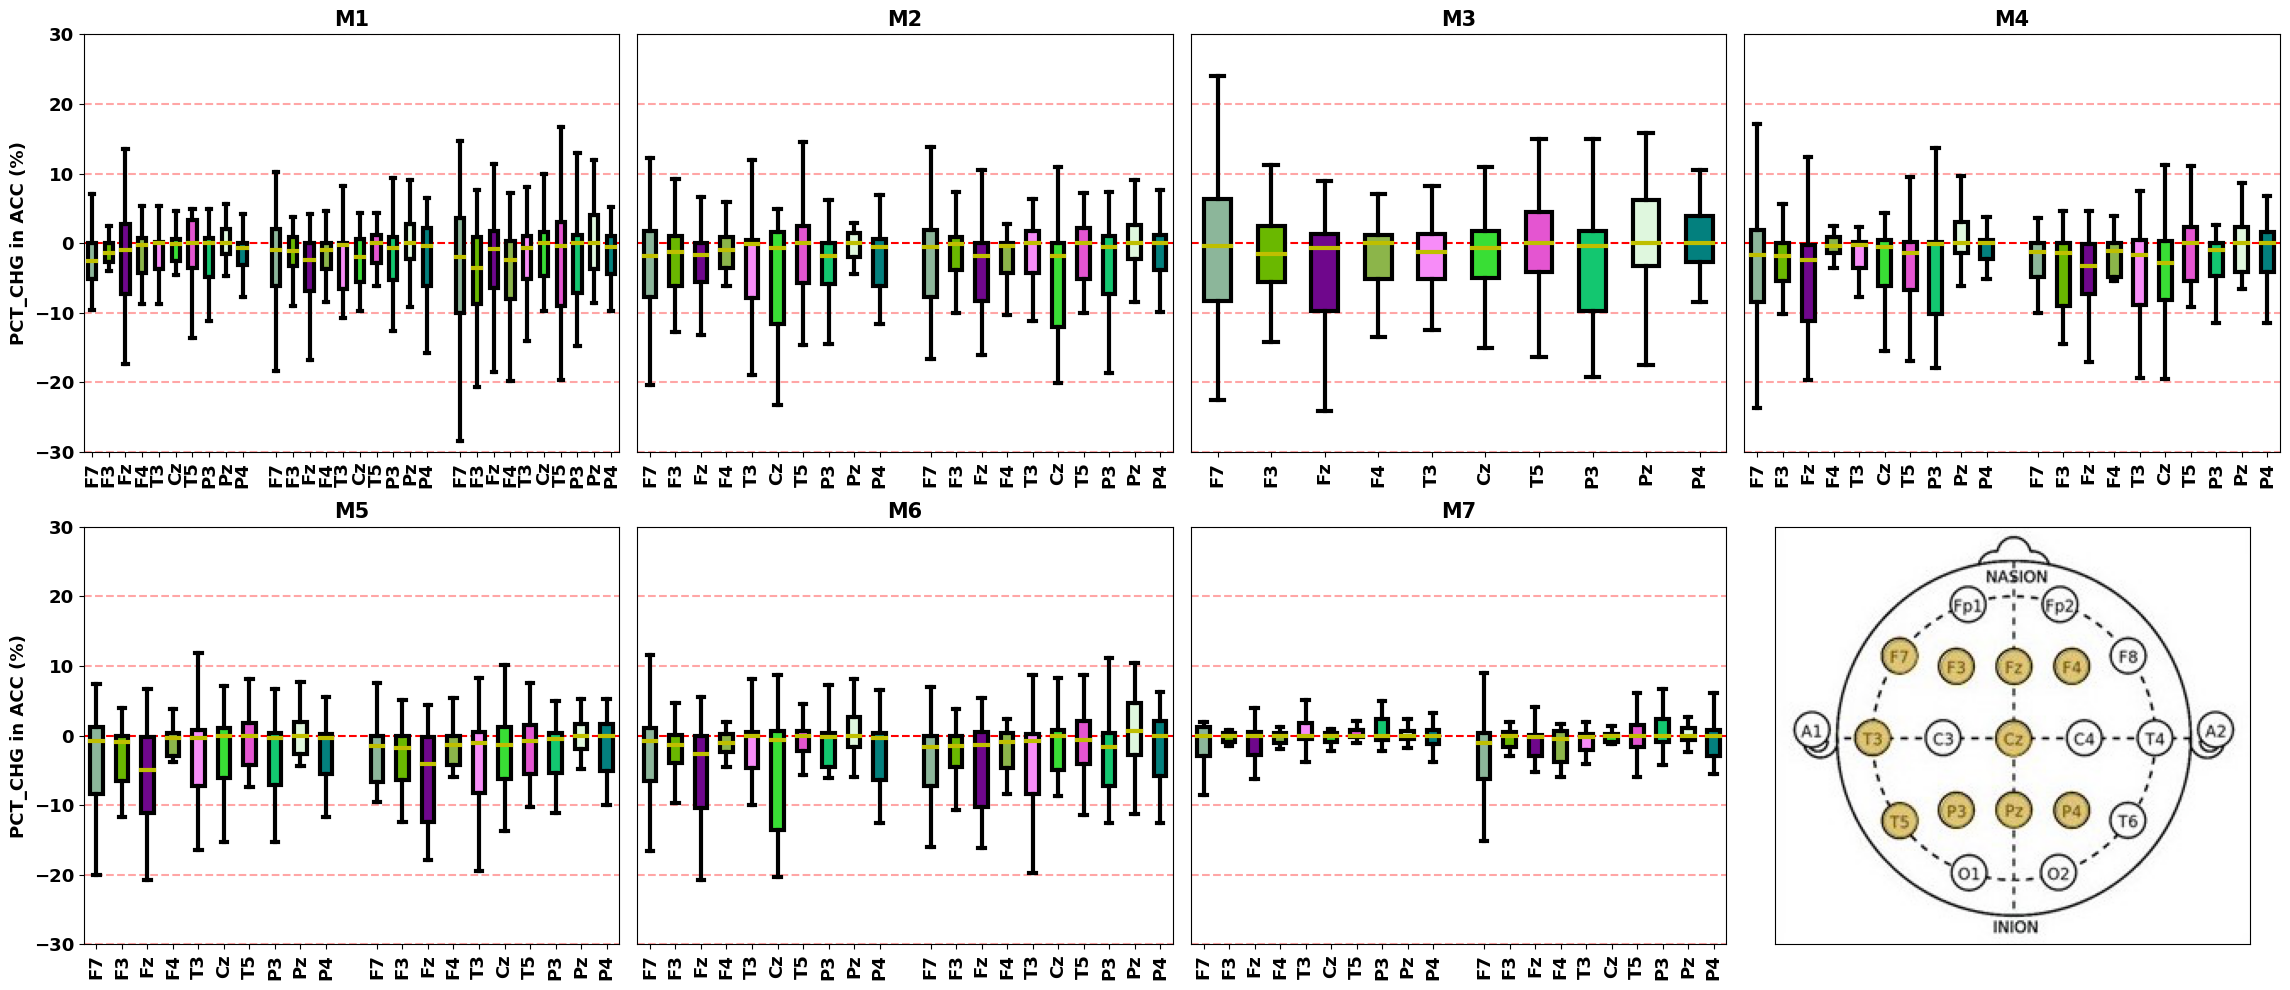

In [23]:
# GET ONLY TOP 10 CHANNELS
spatial_importance_vals_red = spatial_importance_vals[:,:,include_in_top10]
channels_red = np.array(channels)[include_in_top10]

# MAKE FIGURE FOR SPATIAL EXPLAINABILITY RESULTS

# Define Titles
titles = ['M1','M2','M3','M4','M5','M6','M7']

# Make Figure
plt.figure(figsize=(23,10))
for i in np.arange(np.max(index2)+1):
    plt.subplot(int(np.ceil((np.max(index2)+1)/4)),4,i+1)
    
    # Get X Indices
    model_idx = i*np.ones_like(index2)== index2
    n_models = np.sum(model_idx)
    n_channels = np.shape(spatial_importance_vals_red)[2]
    x_idx = get_idx(n_channels,n_models,n_models)
    
    # Get X-Tick Labels
    channels2 = get_labels(channels_red,n_models)
    
    # Plot Horizontal Lines
    for hline in range(-8,5):
        if hline != 0:
            plt.hlines([10*hline],-0.5,np.max(x_idx)+0.5,'r','--',alpha=0.35)
        else:
            plt.hlines([10*hline],-0.5,np.max(x_idx)+0.5,'r','--',alpha=1)
    
    # Rearrange Data
    spat_imp = []
    for m in range(n_models):
        spat_imp.extend(spatial_importance_vals_red[model_idx,:,:][m,:,:].T)
        
    bplot = plt.boxplot(spat_imp,positions=x_idx,patch_artist=True,showfliers=False)
    
    plt.xticks(x_idx,channels2,weight='bold',fontsize=13,rotation=90)
    plt.yticks(weight='bold',fontsize=13)
    plt.title(titles[i],weight='bold',fontsize=15)
    plt.ylim([-30,30])
    
    if i in [0,4]:
        plt.ylabel('PCT_CHG in ACC (%)',weight='bold',fontsize=13)
    else:
        plt.yticks([])
        
    # Set Whisker Color
    for whisker in bplot['whiskers']:
        whisker.set(color='k',linewidth=3)
    
    # Set Caps Color
    for cap in bplot['caps']:
        cap.set(color='k',linewidth=3)
    
    # Set Box Outline Color
    for box in bplot['boxes']:
        box.set(color='k',linewidth=3)
        
    # Set Median Color
    for med in bplot['medians']:
        med.set(color='y',linewidth=3)
    
    # Set Face color
    for count_outer in range(0,n_models):
        colors = ['b','r','g','c','y','w','tab:pink']
        for count in range(n_channels):
            
            patch = bplot['boxes'][count + (count_outer*n_channels)]
            np.random.seed(count)
            patch.set_facecolor(np.random.rand(3,))
            
import matplotlib.image as mpimg

img=mpimg.imread(image_path)
plt.subplot(int(np.ceil((np.max(index2)+1)/4)),4,i+2)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

plt.tight_layout()

plt.savefig('/home/users/cellis42/Spectral_Explainability/DataAugmentation/EMBC2024/Spatial_Importance.png')

In [2]:
index = ['M1.1','M1.2','M1.3','M2.1','M2.2','M3.1','M4.1','M4.2','M5.1','M5.2','M6.1','M6.2','M7.1','M7.2']

for i in range(10):
    print(index[i])

M1.1
M1.2
M1.3
M2.1
M2.2
M3.1
M4.1
M4.2
M5.1
M5.2
